In [23]:
import pickle
import json
import numpy as np
import os

In [24]:
with open('/home/parinayok/nutr1m/data_crawl/food.com_annotated_nutr_per_recipe_old.json') as f:
    nutr_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_food_ids_per_recipes.json') as f:
    food_ids_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/simplified_weighted_food_ids_per_recipes.json') as f:
    weighted_food_ids_per_recipes = json.load(f)
with open('/srv/datasets2/recipe1m+/food.com_data_rescaled/nutr/food.com_nutr_g_per_recipe.json') as f:
    nutr_g_per_recipes = json.load(f)

In [25]:
def cal_iou(input_1, input_2):
    input_1 = set(input_1)
    input_2 = set(input_2)
    u = input_1.union(input_2)
    i = input_1.intersection(input_2)
    return len(i) / len(u)

def direct_cal_mean_iou(out_ingrs,food_ids_per_recipes):
    ious = []
    for recipe_id, pred_ingrs in out_ingrs.items():
        ious.append(cal_iou(food_ids_per_recipes[recipe_id],pred_ingrs))
    iou = sum(ious)/len(ious) * 100
    return iou

def direct_pred_nutr(out_nutr, nutr_per_recipes):
    gts = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    preds = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    absolute_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    symmetric_percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }

    for recipe_id, pred_nutr in out_nutr.items():
        gt_nutr = nutr_per_recipes[recipe_id]
        for nutr_name in gts.keys():
            gts[nutr_name].append(gt_nutr[nutr_name])
            preds[nutr_name].append(pred_nutr[nutr_name])
            absolute_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name]))
            if gt_nutr[nutr_name] < 0.1:
                percentage_errors[nutr_name].append(0)
            else:
                percentage_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/gt_nutr[nutr_name])
            if gt_nutr[nutr_name] + pred_nutr[nutr_name] < 0.1:
                symmetric_percentage_errors[nutr_name].append(0)
            else:
                symmetric_percentage_errors[nutr_name].append(2*abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/(gt_nutr[nutr_name] + pred_nutr[nutr_name]))
    return gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors

In [26]:
def cal_weighted_iou(input_1, input_2, w_1, w_2):
    all_weight = sum(w_1) + sum(w_2)
    intersect_weight = 0.
    for i, ingr in enumerate(input_1):
        if ingr in input_2:
            j = input_2.index(ingr)
            intersect_weight += w_1[i] + w_2[j]
    return intersect_weight / all_weight

def cal_mean_iou(im2recipe_dict,food_ids_per_recipes,weighted_food_ids_per_recipes):
    ious = []
    weighted_ious = []
    for recipe_id, results in im2recipe_dict.items():
        result = results[0]
        ious.append(cal_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result]))
        weighted_ious.append(cal_weighted_iou(food_ids_per_recipes[recipe_id],food_ids_per_recipes[result],weighted_food_ids_per_recipes[recipe_id]['weight'],weighted_food_ids_per_recipes[result]['weight']))
    iou = sum(ious)/len(ious) * 100
    weighted_iou = sum(weighted_ious)/len(weighted_ious) * 100
    return iou, weighted_iou

def pred_nutr(im2recipe_dict, nutr_per_recipes, top_k: int):

    gts = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    preds = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    absolute_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }
    symmetric_percentage_errors = {
        'energy': [],
        'fat': [],
        'carb': [],
        'protein': [],
    }

    for recipe_id, results in im2recipe_dict.items():
        top_k_results = results[:top_k]
        gt_nutr = nutr_per_recipes[recipe_id]
        pred_nutr = {}
        for nutr_name in gts.keys():
            pred_nutr[nutr_name] = sum([nutr_per_recipes[result][nutr_name] for result in top_k_results]) / top_k
        for nutr_name in gts.keys():
            gts[nutr_name].append(gt_nutr[nutr_name])
            preds[nutr_name].append(pred_nutr[nutr_name])
            absolute_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name]))
            if gt_nutr[nutr_name] < 0.1:
                percentage_errors[nutr_name].append(0)
            else:
                percentage_errors[nutr_name].append(abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/gt_nutr[nutr_name])
            if gt_nutr[nutr_name] + pred_nutr[nutr_name] < 0.1:
                symmetric_percentage_errors[nutr_name].append(0)
            else:
                symmetric_percentage_errors[nutr_name].append(2*abs(pred_nutr[nutr_name] - gt_nutr[nutr_name])/(gt_nutr[nutr_name] + pred_nutr[nutr_name]))
    return gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors


In [36]:
dir = 'vlpcook/base'
dir_direct = 'deep_ht/direct_ingrs_3_branches/no_nutr/food_test'
im2recipe = np.load(f'../out/models/{dir}/im2recipe.npy')
recipe2im = np.load(f'../out/models/{dir}/recipe2im.npy')
with open(f'../out/models/{dir}/img_path','rb') as f:
    img_path = pickle.load(f)
with open(f'../out/models/{dir}/saved_ids','rb') as f:
    saved_ids = pickle.load(f)
with open(f'../out/models/{dir_direct}/out_nutr.json','r') as f:
    out_nutr = json.load(f)
with open(f'../out/models/{dir_direct}/out_ingrs.json','r') as f:
    out_ingrs = json.load(f)
with open(f'results_50/{dir}.json') as f:
    im2recipe_dict = json.load(f)

In [18]:
# nearest top 1
mads = {'energy': 1395.8724423387391,
 'fat': 81.84545318660784,
 'carb': 191.63350253321084,
 'protein': 58.820853333231774}
nutr_list = ['energy','fat','carb','protein']
im2direct_recipe = {}
for recipe_id, results in im2recipe_dict.items():
    direct_nutr =  out_nutr[recipe_id]
    pred_nutr_list = []
    for result in results:
        p_nutr = {}
        for nutr_name in nutr_list:
            p_nutr[nutr_name] = nutr_g_per_recipes[result][nutr_name]
        pred_nutr_list.append(p_nutr)

    ase_list = []
    for i in range(len(pred_nutr_list)):
        ase = 0.
        for nutr_name in nutr_list:
            absolute_error = abs(pred_nutr_list[i][nutr_name] - direct_nutr[nutr_name])
            nutr_ase = absolute_error / mads[nutr_name]
            ase += nutr_ase
        ase_list.append(ase)

    im2direct_recipe[recipe_id] = [results[np.argmin(np.array(ase_list))]]

In [19]:
# #top 1 IOU
# iou, weighted_iou = cal_mean_iou(im2recipe_dict,food_ids_per_recipes,weighted_food_ids_per_recipes)
# print(f'{iou:.02f}%')
# print(f'{weighted_iou:.02f}%')

In [20]:
# #direct IOU
# iou = direct_cal_mean_iou(out_ingrs,food_ids_per_recipes)
# print(f'{iou:.03f}%')

In [21]:
iou, weighted_iou = cal_mean_iou(im2direct_recipe,food_ids_per_recipes,weighted_food_ids_per_recipes)
print(f'{iou:.03f}%')
print(f'{weighted_iou:.03f}%')

25.075%
47.399%


In [22]:
# nearest top 1
# recipe
gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors = pred_nutr(im2direct_recipe,nutr_per_recipes,1)
all_mase = []
all_mad = {}
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    mad = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    mase = mae / mad
    all_mad[nutr_name] = mad
    all_mase.append(mase)
    print(f'{nutr_name}: MAE = {mae:.03f}, MASE = {mase:.03f}')
print(f'{sum(all_mase)/4:.03f}')
#gram
gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors = pred_nutr(im2direct_recipe,nutr_g_per_recipes,1)
all_mase = []
all_mad = {}
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    mad = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    mase = mae / mad
    all_mad[nutr_name] = mad
    all_mase.append(mase)
    print(f'{nutr_name}: MAE = {mae:.03f}, MASE = {mase:.03f}')
print(f'{sum(all_mase)/4:.03f}')

energy: MAE = 1281.782, MASE = 0.918
fat: MAE = 73.284, MASE = 0.895
carb: MAE = 148.101, MASE = 0.773
protein: MAE = 48.580, MASE = 0.826
0.853
energy: MAE = 54.262, MASE = 0.540
fat: MAE = 4.986, MASE = 0.698
carb: MAE = 7.091, MASE = 0.444
protein: MAE = 2.236, MASE = 0.582
0.566


In [29]:
#top k
# #per recipe
for k in [1,5,10]:
    gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors = pred_nutr(im2recipe_dict,nutr_per_recipes,k)
    all_mase = []
    all_mad = {}
    for nutr_name in gts.keys():
        mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
        m = np.array(gts[nutr_name]).mean()
        mad = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
        mase = mae / mad
        all_mad[nutr_name] = mad
        all_mase.append(mase)
        print(f'{nutr_name}: MAE = {mae:.02f}, MASE = {mase:.03f}')
    print(f'{sum(all_mase)/4:.03f}')
#per gram
for k in [1,5,10]:
    gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors = pred_nutr(im2recipe_dict,nutr_g_per_recipes,k)
    all_mase = []
    all_mad = {}
    for nutr_name in gts.keys():
        mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
        m = np.array(gts[nutr_name]).mean()
        mad = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
        mase = mae / mad
        all_mad[nutr_name] = mad
        all_mase.append(mase)
        print(f'{nutr_name}: MAE = {mae:.02f}, MASE = {mase:.03f}')
    print(f'{sum(all_mase)/4:.03f}')

energy: MAE = 1270.35, MASE = 0.910
fat: MAE = 78.62, MASE = 0.961
carb: MAE = 143.33, MASE = 0.748
protein: MAE = 48.08, MASE = 0.817
0.859
energy: MAE = 1060.26, MASE = 0.760
fat: MAE = 65.33, MASE = 0.798
carb: MAE = 121.74, MASE = 0.635
protein: MAE = 41.38, MASE = 0.703
0.724
energy: MAE = 1025.86, MASE = 0.735
fat: MAE = 63.20, MASE = 0.772
carb: MAE = 119.22, MASE = 0.622
protein: MAE = 40.29, MASE = 0.685
0.704
energy: MAE = 67.34, MASE = 0.671
fat: MAE = 6.22, MASE = 0.871
carb: MAE = 8.32, MASE = 0.520
protein: MAE = 2.59, MASE = 0.675
0.684
energy: MAE = 56.08, MASE = 0.559
fat: MAE = 5.19, MASE = 0.727
carb: MAE = 7.17, MASE = 0.449
protein: MAE = 2.24, MASE = 0.583
0.579
energy: MAE = 55.19, MASE = 0.550
fat: MAE = 5.09, MASE = 0.714
carb: MAE = 7.12, MASE = 0.445
protein: MAE = 2.21, MASE = 0.576
0.571


In [64]:
#direct
# per gram
gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors = direct_pred_nutr(out_nutr,nutr_g_per_recipes)
all_mase = []
all_mad = {}
for nutr_name in gts.keys():
    mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
    m = np.array(gts[nutr_name]).mean()
    mad = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
    mase = mae / mad
    all_mad[nutr_name] = mad
    all_mase.append(mase)
    print(f'{nutr_name}: MAE = {mae:.03f}, MASE = {mase:.03f}')
print(f'{sum(all_mase)/4:.03f}')

energy: MAE = 53.983, MASE = 0.538
fat: MAE = 4.893, MASE = 0.685
carb: MAE = 6.986, MASE = 0.437
protein: MAE = 2.159, MASE = 0.562
0.556


In [37]:
#k ablation per gram
k_ablation_mase = []
for k in range(1,51):
    gts, preds, absolute_errors, percentage_errors, symmetric_percentage_errors = pred_nutr(im2recipe_dict,nutr_g_per_recipes,k)
    all_mase = []
    all_mad = {}
    for nutr_name in gts.keys():
        mae = sum(absolute_errors[nutr_name])/len(absolute_errors[nutr_name])
        m = np.array(gts[nutr_name]).mean()
        mad = sum(np.abs(np.array(gts[nutr_name]) - m))/(len(gts[nutr_name]))
        mase = mae / mad
        all_mad[nutr_name] = mad
        all_mase.append(mase)
        # print(f'{nutr_name}: MAE = {mae:.02f}, MASE = {mase:.03f}')
    # print(f'{sum(all_mase)/4:.03f}')
    k_ablation_mase.append(sum(all_mase)/4)

In [38]:
save_path = f'k_ablation/{dir}.json'
os.makedirs(os.path.dirname(save_path),exist_ok=True)
with open(save_path,'w') as f:
    json.dump(k_ablation_mase,f,indent=2)

In [39]:
with open('k_ablation/deep_ht/direct_ingrs_3_branches/no_nutr/food_test_recipe_only.json') as f:
    our_ks = json.load(f)
with open('k_ablation/ht/base.json') as f:
    ht_ks = json.load(f)
with open('k_ablation/vlpcook/base.json') as f:
    vlp_ks = json.load(f)

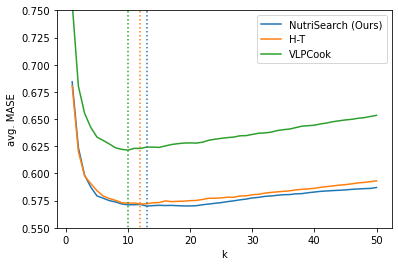

In [56]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1,51),our_ks)
plt.plot(range(1,51),ht_ks)
plt.plot(range(1,51),vlp_ks)
plt.plot([np.array(our_ks).argmin() + 1]*2, [0,1], ':', c='tab:blue')
plt.plot([np.array(ht_ks).argmin() + 1]*2, [0,1], ':', c='tab:orange')
plt.plot([np.array(vlp_ks).argmin() + 1]*2, [0,1], ':', c='tab:green')
plt.ylim([0.550,0.750])
plt.xlabel('k')
plt.ylabel('avg. MASE')
plt.legend(['NutriSearch (Ours)','H-T','VLPCook'])
plt.show()

In [51]:
np.array(our_ks).argmin()

12